In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_loader, test_loader = mnist()

In [3]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 384)
        self.fc2 = nn.Linear(384, 256)
        self.fc3 = nn.Linear(256, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
        print(line + losses)

In [5]:
def test(models, log=None):
    test_size = len(test_loader.dataset)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [6]:
models = {'softmax' : Net(), 'log_softmax' : Net(True)}
test_log = {k: [] for k in models}

epochs = 50
for epoch in range(1, epochs+1):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses softmax: 2.300134 log_softmax: 2.333626
Train Epoch: 1 [10000/60000 (17%)]	Losses softmax: 0.697596 log_softmax: 0.728311
Train Epoch: 1 [20000/60000 (33%)]	Losses softmax: 0.519777 log_softmax: 0.464163
Train Epoch: 1 [30000/60000 (50%)]	Losses softmax: 0.340400 log_softmax: 0.253427
Train Epoch: 1 [40000/60000 (67%)]	Losses softmax: 0.182648 log_softmax: 0.219942
Train Epoch: 1 [50000/60000 (83%)]	Losses softmax: 0.307562 log_softmax: 0.321626
Train Epoch: 1 [60000/60000 (100%)]	Losses softmax: 0.198051 log_softmax: 0.153178
Test set:
softmax: Loss: 0.1555	Accuracy: 9538.0/10000 (95%)
log_softmax: Loss: 0.1499	Accuracy: 9574.0/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Losses softmax: 0.036252 log_softmax: 0.050605
Train Epoch: 2 [10000/60000 (17%)]	Losses softmax: 0.131353 log_softmax: 0.132725
Train Epoch: 2 [20000/60000 (33%)]	Losses softmax: 0.138761 log_softmax: 0.139325
Train Epoch: 2 [30000/60000 (50%)]	Losses softmax: 0.178040 log_softmax:

Train Epoch: 13 [10000/60000 (17%)]	Losses softmax: 0.001779 log_softmax: 0.000986
Train Epoch: 13 [20000/60000 (33%)]	Losses softmax: 0.000353 log_softmax: 0.000425
Train Epoch: 13 [30000/60000 (50%)]	Losses softmax: 0.000521 log_softmax: 0.000611
Train Epoch: 13 [40000/60000 (67%)]	Losses softmax: 0.000344 log_softmax: 0.000404
Train Epoch: 13 [50000/60000 (83%)]	Losses softmax: 0.000369 log_softmax: 0.000390
Train Epoch: 13 [60000/60000 (100%)]	Losses softmax: 0.000362 log_softmax: 0.001148
Test set:
softmax: Loss: 0.0629	Accuracy: 9823.0/10000 (98%)
log_softmax: Loss: 0.0596	Accuracy: 9837.0/10000 (98%)

Train Epoch: 14 [0/60000 (0%)]	Losses softmax: 0.000352 log_softmax: 0.000203
Train Epoch: 14 [10000/60000 (17%)]	Losses softmax: 0.001771 log_softmax: 0.001302
Train Epoch: 14 [20000/60000 (33%)]	Losses softmax: 0.000743 log_softmax: 0.001610
Train Epoch: 14 [30000/60000 (50%)]	Losses softmax: 0.000089 log_softmax: 0.000074
Train Epoch: 14 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 25 [10000/60000 (17%)]	Losses softmax: 0.000424 log_softmax: 0.000270
Train Epoch: 25 [20000/60000 (33%)]	Losses softmax: 0.000366 log_softmax: 0.000485
Train Epoch: 25 [30000/60000 (50%)]	Losses softmax: 0.000245 log_softmax: 0.000166
Train Epoch: 25 [40000/60000 (67%)]	Losses softmax: 0.000247 log_softmax: 0.000497
Train Epoch: 25 [50000/60000 (83%)]	Losses softmax: 0.000199 log_softmax: 0.000270
Train Epoch: 25 [60000/60000 (100%)]	Losses softmax: 0.000399 log_softmax: 0.000267
Test set:
softmax: Loss: 0.0673	Accuracy: 9824.0/10000 (98%)
log_softmax: Loss: 0.0638	Accuracy: 9837.0/10000 (98%)

Train Epoch: 26 [0/60000 (0%)]	Losses softmax: 0.000168 log_softmax: 0.000099
Train Epoch: 26 [10000/60000 (17%)]	Losses softmax: 0.000011 log_softmax: 0.000095
Train Epoch: 26 [20000/60000 (33%)]	Losses softmax: 0.000180 log_softmax: 0.000234
Train Epoch: 26 [30000/60000 (50%)]	Losses softmax: 0.000179 log_softmax: 0.000270
Train Epoch: 26 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 37 [10000/60000 (17%)]	Losses softmax: 0.000093 log_softmax: 0.000105
Train Epoch: 37 [20000/60000 (33%)]	Losses softmax: 0.000105 log_softmax: 0.000059
Train Epoch: 37 [30000/60000 (50%)]	Losses softmax: 0.000088 log_softmax: 0.000043
Train Epoch: 37 [40000/60000 (67%)]	Losses softmax: 0.000302 log_softmax: 0.000291
Train Epoch: 37 [50000/60000 (83%)]	Losses softmax: 0.000200 log_softmax: 0.000085
Train Epoch: 37 [60000/60000 (100%)]	Losses softmax: 0.000058 log_softmax: 0.000079
Test set:
softmax: Loss: 0.0694	Accuracy: 9822.0/10000 (98%)
log_softmax: Loss: 0.0661	Accuracy: 9842.0/10000 (98%)

Train Epoch: 38 [0/60000 (0%)]	Losses softmax: 0.000345 log_softmax: 0.000486
Train Epoch: 38 [10000/60000 (17%)]	Losses softmax: 0.000085 log_softmax: 0.000117
Train Epoch: 38 [20000/60000 (33%)]	Losses softmax: 0.000038 log_softmax: 0.000035
Train Epoch: 38 [30000/60000 (50%)]	Losses softmax: 0.000362 log_softmax: 0.000270
Train Epoch: 38 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 49 [10000/60000 (17%)]	Losses softmax: 0.000005 log_softmax: 0.000006
Train Epoch: 49 [20000/60000 (33%)]	Losses softmax: 0.000065 log_softmax: 0.000042
Train Epoch: 49 [30000/60000 (50%)]	Losses softmax: 0.000137 log_softmax: 0.000060
Train Epoch: 49 [40000/60000 (67%)]	Losses softmax: 0.000126 log_softmax: 0.000127
Train Epoch: 49 [50000/60000 (83%)]	Losses softmax: 0.000050 log_softmax: 0.000086
Train Epoch: 49 [60000/60000 (100%)]	Losses softmax: 0.000111 log_softmax: 0.000105
Test set:
softmax: Loss: 0.0715	Accuracy: 9823.0/10000 (98%)
log_softmax: Loss: 0.0677	Accuracy: 9842.0/10000 (98%)

Train Epoch: 50 [0/60000 (0%)]	Losses softmax: 0.000088 log_softmax: 0.000084
Train Epoch: 50 [10000/60000 (17%)]	Losses softmax: 0.000088 log_softmax: 0.000075
Train Epoch: 50 [20000/60000 (33%)]	Losses softmax: 0.000116 log_softmax: 0.000091
Train Epoch: 50 [30000/60000 (50%)]	Losses softmax: 0.000100 log_softmax: 0.000072
Train Epoch: 50 [40000/60000 (67%)]	Losses softmax: 0.000

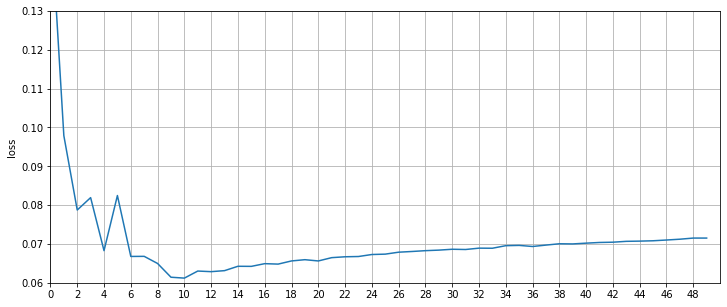

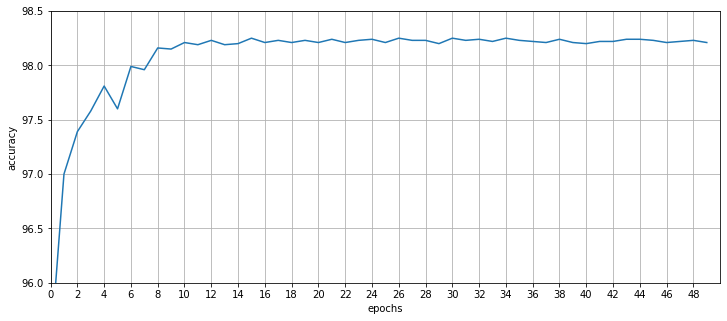

In [8]:
test_loss_softmax = [i[0] for i in test_log['softmax']]
test_acc_softmax = [i[1] for i in test_log['softmax']]
test_loss_log_softmax = [i[0] for i in test_log['log_softmax']]
test_acc_log_softmax = [i[1] for i in test_log['log_softmax']]

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_loss_softmax)
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((0.06, 0.13))
plt.ylabel('loss')
plt.grid()

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_acc_softmax)
plt.xlabel('epochs')
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((96, 98.5))
plt.ylabel('accuracy')
plt.grid()

In [9]:
test_loss_softmax[49]

0.07151763844383004